In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from CybORG import CybORG
from CybORG.Simulator.Scenarios.DroneSwarmScenarioGenerator import DroneSwarmScenarioGenerator
from CybORG.Agents.SimpleAgents.RedDroneWorm import RedDroneWormAgent
from CybORG.Agents.Wrappers import PettingZooParallelWrapper

import torch
from torch_geometric.utils import from_networkx
from ipaddress import IPv4Address
import random
import logging
from torch_geometric.loader import DataLoader
import pickle

# Dataset Creation

In [3]:
def get_link_diagram(cyborg):
    if cyborg.env == 'sim':
        G = cyborg.environment_controller.state.link_diagram.copy()
        return G

In [4]:
def AssignFeatures(cyborg,env):
    drones = GetFeatures(cyborg,env)
    
    #Get graph
    G = cyborg.environment_controller.state.link_diagram.copy()
    G.remove_edges_from(nx.selfloop_edges(G))
    for i in range(len(G.nodes())):
        drone = 'drone_' + str(i)
        G.nodes[drone]['feature'] = drones[drone]

    return G

def CheckAgents(hosts, i):
    drone_name = f'drone_{i}'
    agent_name = 'cmd.sh'
    blue_name = 'blue_drone_session'

    # processes = cyborg.environment_controller.state.hosts[drone_name].processes
    processes = hosts[drone_name].processes
    red = blue = False

    for process in processes:
        if agent_name in str(process):
            red = True
        if blue_name in str(process):
            blue = True
    
    
    return (red and blue)

def BlueExist(cyborg, i):
    drone_name = 'drone_' + str(i)
    agent_name = 'red_agent_' + str(i)

    if cyborg.environment_controller.state.hosts[drone_name].sessions[agent_name] != []:
        return True
    else:
        return False
    

In [5]:
def GetFeatures(cyborg,env):
    drones = {}

    #obs = env.reset()

    n = len(cyborg.environment_controller.state.link_diagram.nodes())
    for i in range(n):
        drone_name = 'drone_' + str(i)
        blue_name = 'blue_agent_' + str(i)
        
        if BlueExist(cyborg, i) == False:
            drones[drone_name] = env.get_observation(blue_name)
        else:
            drones[drone_name] = np.array([0 for i in range(6*n)])
    
    return drones

In [6]:
def to_pyg(hosts,G,n,i):
    MASK = 0x3FFFF
    label = 0
    
    # Convert NetworkX graph to PyG Data object
    graph = from_networkx(G)
    
    # Extract numerical features from the dictionary
    node_features = []
    egoF = G.nodes['drone_'+ str(i)]['feature']
    for j in G.nodes:
        drone = int(j.split('_')[-1])
        features = G.nodes[j]['feature']
        node_features.append(features)


    if CheckAgents(hosts, i):
        label = 1
    else:
        label = 0
  



    node_features = np.array(node_features)
    graph.x = torch.tensor(node_features, dtype=torch.float)
    graph.y = torch.tensor(np.array(label), dtype=torch.long)
 

    return graph, egoF

In [7]:
filename = '../Data/low_priority'
def load_graphs(filename):
    try:
        # Attempt to load the file
        graphs = torch.load(filename)
        return graphs
    except Exception as e:
        # If loading fails, print the error and return an empty list
        #print(f"Failed to load {filename}: {e}")
        return []  # Return an empty list if there was an error

def load_data(filename):
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            return data
    except:
        return []


def GetData(n, rounds, seed):
    
    #logging.getLogger('CybORGLog-Process').setLevel(logging.WARNING)
    sg = DroneSwarmScenarioGenerator(
        starting_num_red=1, 
        default_red_agent=RedDroneWormAgent,
        num_drones=n
    )
    cyborg = CybORG(sg, 'sim', seed=seed)
    
    # Start CybORG simulation
    cyborg.start(0)
    

    all_graphs = load_graphs(f'{filename}.pt')
    dataset = load_data(f'{filename}.pkl')
    
    
    # Run simulation for specified rounds
    for j in range(rounds):
        # print('-------------------------')
        # print(f"Round {cyborg.environment_controller.step_count}")
        env = PettingZooParallelWrapper(env=cyborg)
        drone_graph = AssignFeatures(cyborg,env)

        
        
        for i in range(n):

            name = f'drone_{i}'
            blue_name = f'blue_agent_{i}'

            ego = nx.ego_graph(drone_graph, name, radius=1, center=True, undirected=True, distance=None)

            pyg_graph,node = to_pyg(cyborg.environment_controller.state.hosts.copy(),ego,n,i)
            


            label = pyg_graph.y.item()

            dataset.append((node, label))
            all_graphs.append(pyg_graph)

        

        cyborg.step()
        
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(dataset, f)

    
    torch.save(all_graphs, f"{filename}.pt")
    # print("Saved all rounds in all_graphs.pt")

In [22]:
i = 1
for j in range(i):
    #n = random.randint(17, 20)  # Randomly choose n between 17 and 22
    n = 18
    seed = random.randint(1, 100000)  # Randomly choose a seed, can adjust range as needed
    print(f'{j+1}: GetData(n={n}, seed={seed})')
    with open('../Data/seeds.txt', 'a') as f:
        f.write(f'{seed}\n')
    
    GetData(n=n, rounds=200, seed=seed)


1: GetData(n=18, seed=47148)


C:\Users\Noah\AppData\Local\Temp\ipykernel_41424\2237144700.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs = torch.load(filename)


# Train Graph

In [23]:
filename = '../Data/multidrone'
dataset = torch.load(f'{filename}.pt')

C:\Users\Noah\AppData\Local\Temp\ipykernel_41424\584244886.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(f'{filename}.pt')


In [24]:
import torch
from torch_geometric.datasets import TUDataset
from pprint import pprint


print(len(dataset))
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

32908

Data(edge_index=[2, 14], feature=[5, 108], num_nodes=5, x=[5, 108], y=0)
Number of nodes: 5
Number of edges: 14
Average node degree: 2.80
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [25]:
import random

random.shuffle(dataset)
# train_dataset = dataset[:12000]
# test_dataset = dataset[12000:]

size = len(dataset)
size = size - size//4

train_dataset = dataset[:size]
test_dataset = dataset[size:]


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
    

Number of training graphs: 24681
Number of test graphs: 8227


In [ ]:
n = len(test_dataset)
count = 0
for t in test_dataset:
    if t.y.item() == 0:
        count+=1

print(f'\033[1mPercent of not compromised graphs: \033[0m{count/n}')

Percent of not compromised graphs: 0.3197761703289204


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader

#Specify device manually
use_gpu = True # Set to False to use CPU
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")


# DataLoader (ensure `train_dataset` and `test_dataset` are loaded correctly)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset[0].x.shape[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 0x3FFFF)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

Using device: cuda
GCN(
  (conv1): GCNConv(108, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=262143, bias=True)
)


In [ ]:
from sklearn.metrics import precision_score, recall_score


# Initialize the model, optimizer, and loss function
model = GCN(hidden_channels=64).to(device)  # Move model to GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

losses = []  # Training losses
test_losses = []  # Test losses
accs = []  # Test accuracies
precisions = []  # Test precisions
recalls = []  # Test recalls

# Define the training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)  # Move batch data to GPU
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        total_loss += loss.item()  # Accumulate loss for this epoch.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

    avg_loss = total_loss / len(train_loader)  # Calculate average loss for this epoch.
    losses.append(avg_loss)  # Append the average loss to the list.

# Define the testing loop
def test(loader):
    model.eval()
    correct = 0
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during evaluation.
        for data in loader:  # Iterate in batches over the training/test dataset.
            data = data.to(device)  # Move batch data to GPU
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)  # Compute the loss for the batch.
            total_loss += loss.item()  # Accumulate test loss.
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y).sum())  # Check against ground-truth labels.

            # Collect predictions and true labels for precision and recall
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(loader)  # Calculate average test loss.
    test_losses.append(avg_loss)  # Append the average test loss to the list.
    acc = correct / len(loader.dataset)  # Derive ratio of correct predictions.
    accs.append(acc)  # Append accuracy to the list.

    # Compute precision and recall
    precision = precision_score(all_labels, all_preds, average='macro',zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

    return acc, avg_loss, precision, recall

# Training and testing loop
for epoch in range(1, 101):
    train()
    test_acc, test_loss, precision, recall = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {losses[-1]:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')


Epoch: 001, Train Loss: 4.0827, Test Loss: 1.2274, Test Acc: 0.7951, Precision: 0.2123, Recall: 0.2058
Epoch: 002, Train Loss: 1.2717, Test Loss: 1.0277, Test Acc: 0.8018, Precision: 0.2206, Recall: 0.2139
Epoch: 003, Train Loss: 1.0162, Test Loss: 0.8802, Test Acc: 0.8298, Precision: 0.2453, Recall: 0.2333
Epoch: 004, Train Loss: 0.8886, Test Loss: 0.7763, Test Acc: 0.8400, Precision: 0.2625, Recall: 0.2427
Epoch: 005, Train Loss: 0.8062, Test Loss: 0.7331, Test Acc: 0.8439, Precision: 0.2509, Recall: 0.2334
Epoch: 006, Train Loss: 0.7451, Test Loss: 0.6933, Test Acc: 0.8538, Precision: 0.2833, Recall: 0.2591
Epoch: 007, Train Loss: 0.7046, Test Loss: 0.6442, Test Acc: 0.8563, Precision: 0.2614, Recall: 0.2661
Epoch: 008, Train Loss: 0.6559, Test Loss: 0.6249, Test Acc: 0.8571, Precision: 0.2704, Recall: 0.2502
Epoch: 009, Train Loss: 0.6239, Test Loss: 0.6429, Test Acc: 0.8620, Precision: 0.2741, Recall: 0.2747
Epoch: 010, Train Loss: 0.5948, Test Loss: 0.5750, Test Acc: 0.8609, Prec

## Graphs

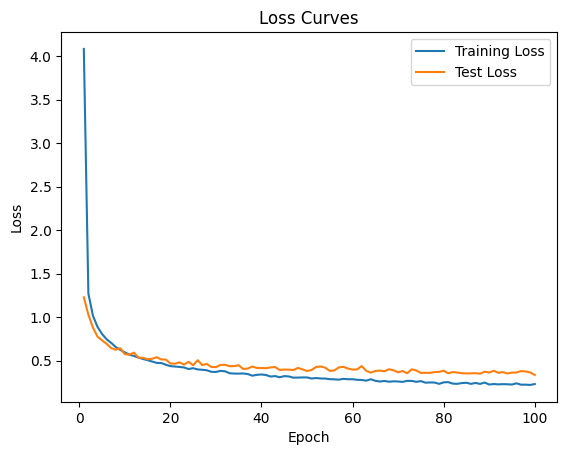

In [ ]:
# Plot the loss curve
plt.plot(range(1, 101), losses, label='Training Loss')
plt.plot(range(1,101), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.savefig('../Data/loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()


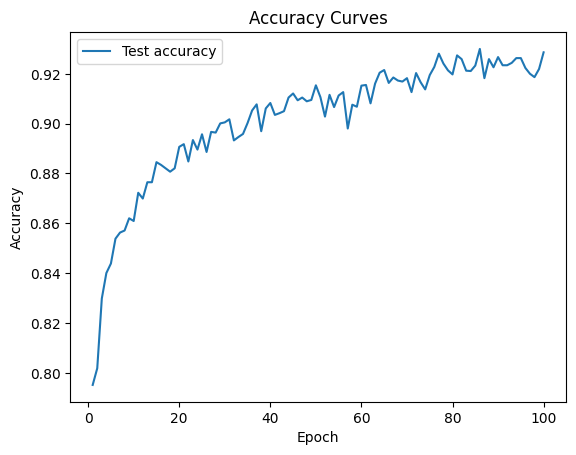

In [ ]:
plt.plot(range(1, 101), accs, label='Test accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.savefig('../Data/accuracy_curve.png', dpi=300, bbox_inches='tight')
plt.show()


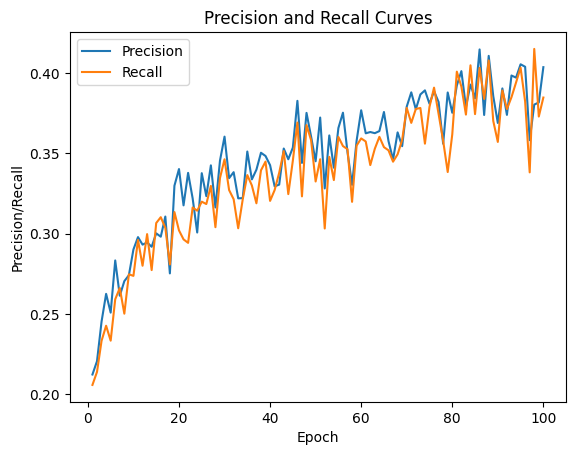

In [ ]:
plt.plot(range(1, 101), precisions, label='Precision')
plt.plot(range(1, 101), recalls, label='Recall')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall Curves')
plt.savefig('../Data/precision_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Train CNN

In [16]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [17]:
with open(f'{filename}.pkl', 'rb') as f:
    pickledata = pickle.load(f)


print(pickledata[0])


random.shuffle(pickledata)

(array([ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 38,  1,  1, 50, 83,  0,  2, 91, 52,  0,  3, 12, 58,
        0,  4, 15,  2,  0,  5, 97,  6,  0,  6, 63, 36,  0,  7, 90,  3,  0,
        8, 38, 25,  0,  9, 31, 34,  0, 10,  2, 82,  0, 11, 56, 17,  0, 12,
        2,  6,  0, 13, 43, 49,  0, 14, 77, 65,  0, 15, 76, 96,  0, 16, 62,
       14,  0, 17, 74, 38,  0]), 0)


In [18]:
# Create a custom Dataset class
class DroneDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x, y = self.data[idx]
        # Convert numpy array to tensor
        x = torch.FloatTensor(x)
        y = torch.tensor(y, dtype=torch.long)
        return x, y

batch_size = 64

train_size = len(pickledata) // 4 * 3
train_dataset = DroneDataset(pickledata[:train_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DroneDataset(pickledata[train_size:])
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

n = len(test_dataset)
count = 0
for t in test_dataset:
    if t[-1] == 0:
        count+=1

print(f'\033[1mPercent of not compromised graphs: \033[0m{count/n}')

    

Percent of not compromised graphs: 0.3249624675856421


In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        
        # Second convolutional layer
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        
        # Third convolutional layer
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        
        # Fully connected layers
        # After two max pooling layers (stride=2), the length is reduced to 27 (108/2/2)
        self.fc1 = nn.Linear(128 * 27, 256)  # 27 is the feature length after max pooling
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 0x3FFFF)  # 2 classes (binary classification)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Reshape input for 1D convolution (batch_size, channels, length)
        x = x.unsqueeze(1)
        
        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool1d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool1d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Initialize model, loss function, and optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
test_losses = []
accuracies = []
precisions = []
recalls = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average training loss for this epoch
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = test_loss / len(test_loader)
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    
    # Store metrics
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}. Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')

Epoch 1/100, Training Loss: 3.5838. Test Loss: 1.9745, Accuracy: 0.5276, Precision: 0.1971, Recall: 0.0972

Epoch 2/100, Training Loss: 2.2379. Test Loss: 1.8906, Accuracy: 0.5454, Precision: 0.1979, Recall: 0.1141

Epoch 3/100, Training Loss: 2.1066. Test Loss: 1.8671, Accuracy: 0.5461, Precision: 0.1995, Recall: 0.1152

Epoch 4/100, Training Loss: 2.0328. Test Loss: 1.8484, Accuracy: 0.5491, Precision: 0.2015, Recall: 0.1165

Epoch 5/100, Training Loss: 1.9991. Test Loss: 1.8257, Accuracy: 0.5541, Precision: 0.2113, Recall: 0.1191

Epoch 6/100, Training Loss: 1.9533. Test Loss: 1.7973, Accuracy: 0.5556, Precision: 0.2060, Recall: 0.1212

Epoch 7/100, Training Loss: 1.9233. Test Loss: 1.7898, Accuracy: 0.5570, Precision: 0.2042, Recall: 0.1226

Epoch 8/100, Training Loss: 1.9053. Test Loss: 1.7832, Accuracy: 0.5615, Precision: 0.2140, Recall: 0.1282

Epoch 9/100, Training Loss: 1.8809. Test Loss: 1.7674, Accuracy: 0.5600, Precision: 0.2079, Recall: 0.1246

Epoch 10/100, Training Loss:

## Graphs

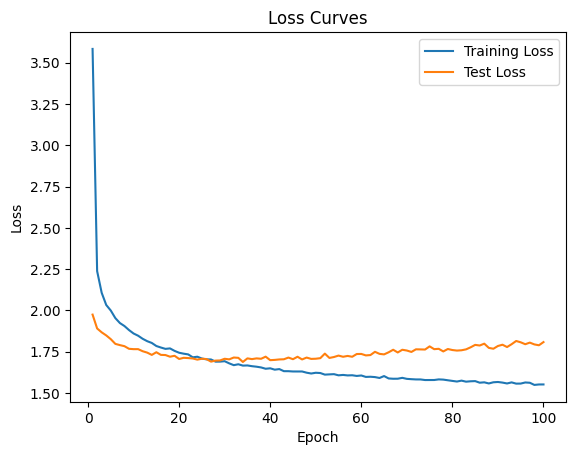

In [20]:
# Plot the loss curve
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1,101), test_losses, label='Test Loss')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.savefig('../Data/NNloss_curves.png', dpi=300, bbox_inches='tight')
plt.show()


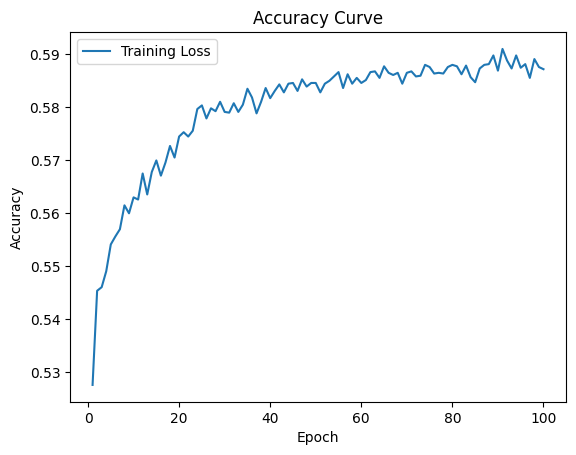

In [21]:
# Plot the loss curve
plt.plot(range(1, 101), accuracies, label='Training Loss')


plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.savefig('../Data/NNAcc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

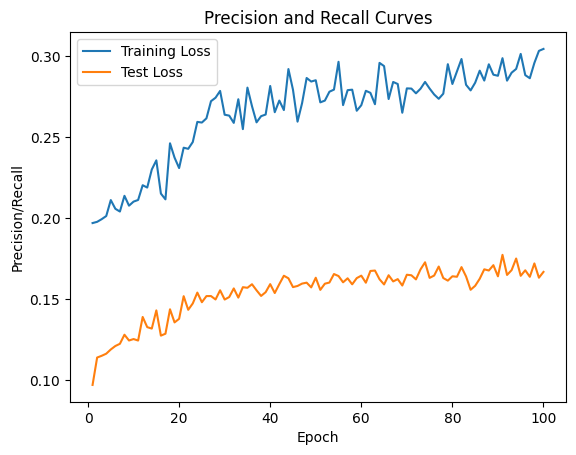

In [22]:
# Plot the loss curve
plt.plot(range(1, 101), precisions, label='Training Loss')
plt.plot(range(1,101), recalls, label='Test Loss')

plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall Curves')
plt.savefig('../Data/NNPandR_curves.png', dpi=300, bbox_inches='tight')
plt.show()